In [8]:
# -- MNISTとクラスの手書き文字を使用したニューラルネットワーク --

import torchvision.datasets as datasets
import torchvision.transforms as transforms

data_root = "./data"
data_root_mnist = f"{data_root}/mnist"

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1))
])

transform_hand_digits = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    transforms.Lambda(lambda x: x.view(-1)),
    transforms.Lambda(lambda x: -x)
])

mnist_train_set = datasets.MNIST(
    root = data_root_mnist,
    train = True,
    download = True,
    transform = transform
)

mnist_test_set = datasets.MNIST(
    root = data_root_mnist,
    train = False,
    download = True,
    transform = transform
)

print(f"MNISTの学習データ件数: {len(mnist_train_set)}")
print(f"MNISTのテストデータ件数: {len(mnist_test_set)}")

MNISTの学習データ件数: 60000
MNISTのテストデータ件数: 10000


In [9]:
import shutil
import os
from glob import glob
import random
from PIL import Image

zip_root_hand_digits = "./hand_digits.zip"
data_root_hand_digits = f"{data_root}/hand_digits"
data_root_hand_digits_train = f"{data_root_hand_digits}/train"
data_root_hand_digits_test = f"{data_root_hand_digits}/test"
data_root_hand_digits_tmp = f"{data_root_hand_digits}/tmp"

shutil.unpack_archive(zip_root_hand_digits, data_root_hand_digits_tmp)

for n in range(10):
    no_dir = f"{data_root_hand_digits_train}/{n}"
    os.makedirs(no_dir, exist_ok=True)

for n in range(10):
    no_dir = f"{data_root_hand_digits_test}/{n}"
    os.makedirs(no_dir, exist_ok=True)

my_hand_digits_images = glob(f"{data_root_hand_digits_tmp}/*.png")

for file in my_hand_digits_images:
    with Image.open(file) as img:
        for angle in range(-45, 46, 5):
            if angle:
                img_r = img.rotate(angle, fillcolor=0xffffff)
                img_r.save(file.replace('.png', f'_A{angle}.png'))

my_hand_digits_images = glob(f'{data_root_hand_digits_tmp}/**/*.png', recursive=True)

print("クラスの手書き文字の画像ファイル数:", len(my_hand_digits_images))
random.seed(0)
random.shuffle(my_hand_digits_images)

train_size = int(0.8 * len(my_hand_digits_images))
test_size = len(my_hand_digits_images) - train_size

for file in my_hand_digits_images[:train_size]:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{data_root_hand_digits_train}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

for file in my_hand_digits_images[train_size:]:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{data_root_hand_digits_test}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

shutil.rmtree(data_root_hand_digits_tmp)

クラスの手書き文字の画像ファイル数: 18962


In [10]:
hand_digits_train_set = datasets.ImageFolder(
    root = data_root_hand_digits_train,
    transform = transform_hand_digits
)

hand_digits_test_set = datasets.ImageFolder(
    root = data_root_hand_digits_test,
    transform = transform_hand_digits
)

In [11]:
from torch.utils.data import ConcatDataset

train_set = ConcatDataset([mnist_train_set, hand_digits_train_set])
test_set = ConcatDataset([mnist_test_set, hand_digits_test_set])

print(f"統合した学習データ件数: {len(train_set)}")
print(f"統合したテストデータ件数: {len(test_set)}")

統合した学習データ件数: 75169
統合したテストデータ件数: 13793


In [12]:
from torch.utils.data import DataLoader

batch_size = 100

train_loader = DataLoader(
    train_set, 
    batch_size = batch_size,
    shuffle = True
)

test_loader = DataLoader(
    test_set,  
    batch_size = batch_size,
    shuffle = True
)

In [13]:
import torch.nn as nn

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_output)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [14]:
import torch
import numpy as np

inputs, labels = next(iter(train_loader))

n_input = inputs[0].shape[0]
n_output = 10
n_hidden = 128

torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

net = Net2(
    n_input = n_input,
    n_output = n_output,
    n_hidden = n_hidden
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net.to(device)

leaning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=leaning_rate)
num_epochs = 50
history = np.zeros((0, 5))

In [15]:
from tqdm import tqdm

for epoch in range(num_epochs):
    n_train_acc, n_val_acc = 0, 0
    train_loss, val_loss = 0, 0
    n_train, n_val = 0, 0

    for inputs, labels in tqdm(train_loader):
        train_batch_size = len(labels)
        n_train += train_batch_size

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        predicted = torch.max(outputs, 1)[1]

        train_loss += loss.item() * train_batch_size
        n_train_acc += (predicted == labels).sum().item()

    for inputs_test, labels_test in test_loader:
        test_batch_size = len(labels_test)
        n_val += test_batch_size

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        outputs_test = net(inputs_test)

        loss_test = criterion(outputs_test, labels_test)

        predicted_test = torch.max(outputs_test, 1)[1]

        val_loss += loss_test.item() * test_batch_size
        n_val_acc += (predicted_test == labels_test).sum().item()

    train_acc = n_train_acc / n_train
    val_acc = n_val_acc / n_val
    ave_train_loss = train_loss / n_train
    ave_val_loss = val_loss / n_val

    print (f'Epoch [{epoch + 1}/{num_epochs}], loss: {ave_train_loss:.5f} acc: {train_acc:.5f} val_loss: {ave_val_loss:.5f}, val_acc: {val_acc:.5f}')

    item = np.array([epoch + 1, ave_train_loss, train_acc, ave_val_loss, val_acc])
    history = np.vstack((history, item))

100%|██████████| 752/752 [02:54<00:00,  4.31it/s]


Epoch [1/50], loss: 1.36878 acc: 0.60858 val_loss: 0.82550, val_acc: 0.75379


100%|██████████| 752/752 [00:45<00:00, 16.45it/s]


Epoch [2/50], loss: 0.69497 acc: 0.79867 val_loss: 0.70738, val_acc: 0.79388


100%|██████████| 752/752 [00:42<00:00, 17.55it/s]


Epoch [3/50], loss: 0.61483 acc: 0.82332 val_loss: 0.65851, val_acc: 0.80831


100%|██████████| 752/752 [00:44<00:00, 16.92it/s]


Epoch [4/50], loss: 0.56501 acc: 0.83714 val_loss: 0.60243, val_acc: 0.82281


100%|██████████| 752/752 [00:43<00:00, 17.32it/s]


Epoch [5/50], loss: 0.52002 acc: 0.84942 val_loss: 0.56426, val_acc: 0.83484


100%|██████████| 752/752 [00:44<00:00, 16.72it/s]


Epoch [6/50], loss: 0.47764 acc: 0.86248 val_loss: 0.52322, val_acc: 0.84521


100%|██████████| 752/752 [00:44<00:00, 17.08it/s]


Epoch [7/50], loss: 0.43652 acc: 0.87299 val_loss: 0.47987, val_acc: 0.85681


100%|██████████| 752/752 [00:44<00:00, 16.97it/s]


Epoch [8/50], loss: 0.39858 acc: 0.88422 val_loss: 0.43430, val_acc: 0.87109


100%|██████████| 752/752 [00:19<00:00, 38.95it/s]


Epoch [9/50], loss: 0.36399 acc: 0.89389 val_loss: 0.40081, val_acc: 0.88204


100%|██████████| 752/752 [00:20<00:00, 37.25it/s]


Epoch [10/50], loss: 0.33369 acc: 0.90298 val_loss: 0.37132, val_acc: 0.88835


100%|██████████| 752/752 [00:20<00:00, 36.83it/s]


Epoch [11/50], loss: 0.30736 acc: 0.91030 val_loss: 0.34890, val_acc: 0.89495


100%|██████████| 752/752 [00:20<00:00, 36.85it/s]


Epoch [12/50], loss: 0.28371 acc: 0.91724 val_loss: 0.31960, val_acc: 0.90546


100%|██████████| 752/752 [00:20<00:00, 36.42it/s]


Epoch [13/50], loss: 0.26385 acc: 0.92377 val_loss: 0.30090, val_acc: 0.91039


100%|██████████| 752/752 [00:20<00:00, 36.70it/s]


Epoch [14/50], loss: 0.24587 acc: 0.92935 val_loss: 0.28373, val_acc: 0.91604


100%|██████████| 752/752 [00:20<00:00, 37.23it/s]


Epoch [15/50], loss: 0.23010 acc: 0.93423 val_loss: 0.26848, val_acc: 0.91974


100%|██████████| 752/752 [00:19<00:00, 39.46it/s]


Epoch [16/50], loss: 0.21616 acc: 0.93819 val_loss: 0.25105, val_acc: 0.92489


100%|██████████| 752/752 [00:20<00:00, 36.89it/s]


Epoch [17/50], loss: 0.20344 acc: 0.94168 val_loss: 0.24118, val_acc: 0.92793


100%|██████████| 752/752 [00:20<00:00, 37.39it/s]


Epoch [18/50], loss: 0.19155 acc: 0.94551 val_loss: 0.23078, val_acc: 0.92975


100%|██████████| 752/752 [00:19<00:00, 37.85it/s]


Epoch [19/50], loss: 0.18140 acc: 0.94782 val_loss: 0.21828, val_acc: 0.93236


100%|██████████| 752/752 [00:20<00:00, 37.47it/s]


Epoch [20/50], loss: 0.17186 acc: 0.95042 val_loss: 0.20878, val_acc: 0.93678


100%|██████████| 752/752 [00:19<00:00, 37.87it/s]


Epoch [21/50], loss: 0.16289 acc: 0.95324 val_loss: 0.20326, val_acc: 0.93707


100%|██████████| 752/752 [00:19<00:00, 37.95it/s]


Epoch [22/50], loss: 0.15545 acc: 0.95497 val_loss: 0.19118, val_acc: 0.94193


100%|██████████| 752/752 [00:19<00:00, 38.07it/s]


Epoch [23/50], loss: 0.14784 acc: 0.95797 val_loss: 0.18308, val_acc: 0.94272


100%|██████████| 752/752 [00:19<00:00, 37.99it/s]


Epoch [24/50], loss: 0.14031 acc: 0.96013 val_loss: 0.17776, val_acc: 0.94446


100%|██████████| 752/752 [00:19<00:00, 37.99it/s]


Epoch [25/50], loss: 0.13388 acc: 0.96182 val_loss: 0.17284, val_acc: 0.94490


100%|██████████| 752/752 [00:19<00:00, 38.70it/s]


Epoch [26/50], loss: 0.12820 acc: 0.96388 val_loss: 0.17331, val_acc: 0.94613


100%|██████████| 752/752 [00:20<00:00, 37.47it/s]


Epoch [27/50], loss: 0.12257 acc: 0.96542 val_loss: 0.15944, val_acc: 0.95121


100%|██████████| 752/752 [00:19<00:00, 38.04it/s]


Epoch [28/50], loss: 0.11729 acc: 0.96698 val_loss: 0.16079, val_acc: 0.94997


100%|██████████| 752/752 [00:19<00:00, 38.47it/s]


Epoch [29/50], loss: 0.11256 acc: 0.96864 val_loss: 0.15068, val_acc: 0.95425


100%|██████████| 752/752 [00:19<00:00, 37.78it/s]


Epoch [30/50], loss: 0.10803 acc: 0.96983 val_loss: 0.15039, val_acc: 0.95432


100%|██████████| 752/752 [00:19<00:00, 38.61it/s]


Epoch [31/50], loss: 0.10351 acc: 0.97132 val_loss: 0.14301, val_acc: 0.95614


100%|██████████| 752/752 [00:19<00:00, 38.11it/s]


Epoch [32/50], loss: 0.09948 acc: 0.97233 val_loss: 0.14453, val_acc: 0.95447


100%|██████████| 752/752 [00:19<00:00, 37.92it/s]


Epoch [33/50], loss: 0.09544 acc: 0.97385 val_loss: 0.14388, val_acc: 0.95614


100%|██████████| 752/752 [00:20<00:00, 37.44it/s]


Epoch [34/50], loss: 0.09191 acc: 0.97435 val_loss: 0.13637, val_acc: 0.95780


100%|██████████| 752/752 [00:19<00:00, 38.22it/s]


Epoch [35/50], loss: 0.08821 acc: 0.97565 val_loss: 0.13409, val_acc: 0.95773


100%|██████████| 752/752 [00:19<00:00, 38.00it/s]


Epoch [36/50], loss: 0.08497 acc: 0.97721 val_loss: 0.13231, val_acc: 0.95715


100%|██████████| 752/752 [00:19<00:00, 37.67it/s]


Epoch [37/50], loss: 0.08181 acc: 0.97786 val_loss: 0.13065, val_acc: 0.95947


100%|██████████| 752/752 [00:19<00:00, 38.27it/s]


Epoch [38/50], loss: 0.07923 acc: 0.97863 val_loss: 0.12135, val_acc: 0.96165


100%|██████████| 752/752 [00:20<00:00, 37.56it/s]


Epoch [39/50], loss: 0.07612 acc: 0.97974 val_loss: 0.14258, val_acc: 0.95541


100%|██████████| 752/752 [00:20<00:00, 36.44it/s]


Epoch [40/50], loss: 0.07377 acc: 0.98019 val_loss: 0.11791, val_acc: 0.96382


100%|██████████| 752/752 [00:18<00:00, 41.26it/s]


Epoch [41/50], loss: 0.07089 acc: 0.98136 val_loss: 0.11925, val_acc: 0.96259


100%|██████████| 752/752 [00:20<00:00, 36.25it/s]


Epoch [42/50], loss: 0.06849 acc: 0.98196 val_loss: 0.12169, val_acc: 0.96310


100%|██████████| 752/752 [00:19<00:00, 37.87it/s]


Epoch [43/50], loss: 0.06623 acc: 0.98292 val_loss: 0.11265, val_acc: 0.96484


100%|██████████| 752/752 [00:19<00:00, 38.16it/s]


Epoch [44/50], loss: 0.06409 acc: 0.98330 val_loss: 0.11075, val_acc: 0.96549


100%|██████████| 752/752 [00:19<00:00, 37.97it/s]


Epoch [45/50], loss: 0.06150 acc: 0.98453 val_loss: 0.11040, val_acc: 0.96730


100%|██████████| 752/752 [00:19<00:00, 38.13it/s]


Epoch [46/50], loss: 0.05963 acc: 0.98478 val_loss: 0.10863, val_acc: 0.96643


100%|██████████| 752/752 [00:19<00:00, 38.53it/s]


Epoch [47/50], loss: 0.05759 acc: 0.98483 val_loss: 0.12743, val_acc: 0.96005


100%|██████████| 752/752 [00:19<00:00, 38.35it/s]


Epoch [48/50], loss: 0.05536 acc: 0.98600 val_loss: 0.10702, val_acc: 0.96607


100%|██████████| 752/752 [00:20<00:00, 37.17it/s]


Epoch [49/50], loss: 0.05377 acc: 0.98662 val_loss: 0.10574, val_acc: 0.96890


100%|██████████| 752/752 [00:19<00:00, 37.78it/s]


Epoch [50/50], loss: 0.05188 acc: 0.98755 val_loss: 0.10245, val_acc: 0.96904


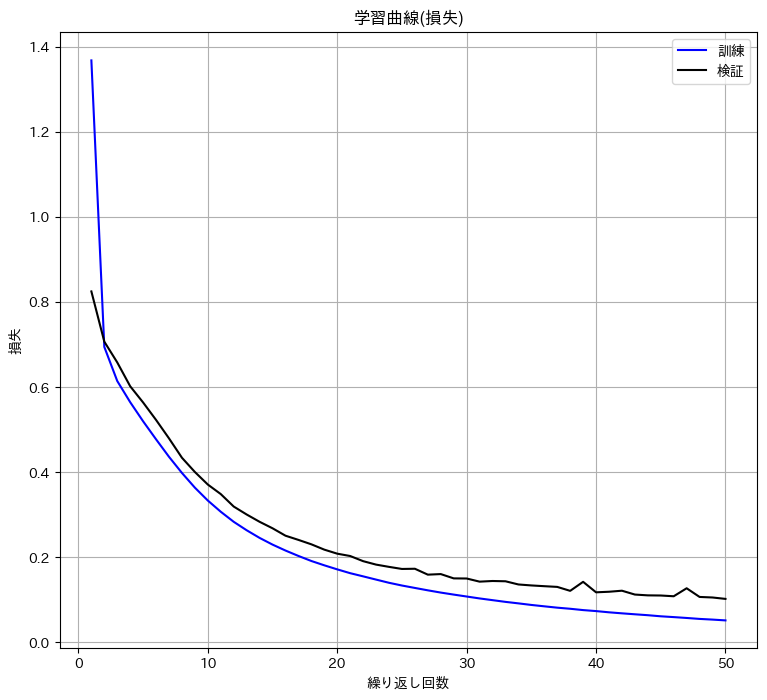

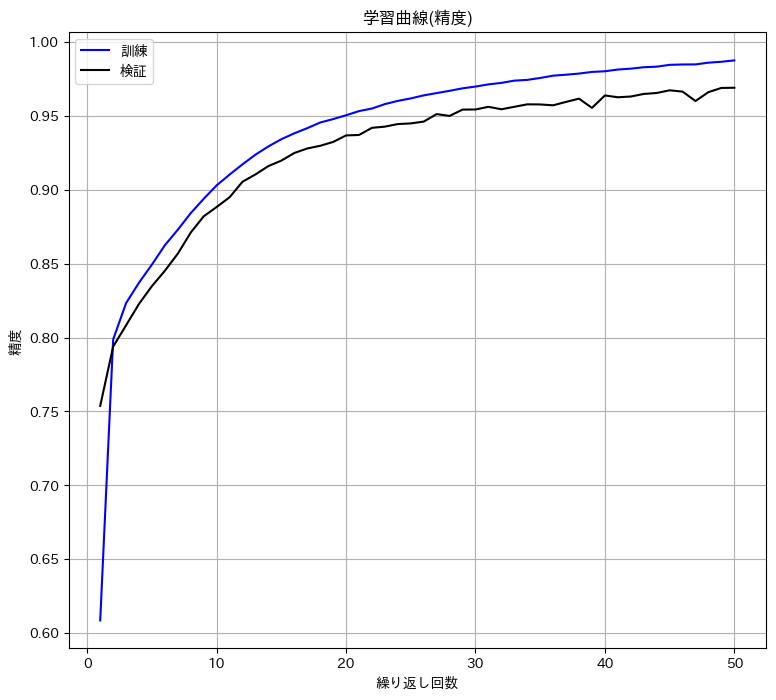

In [16]:
import matplotlib.pyplot as plt
import japanize_matplotlib

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.grid(True)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
mnist_and_hand_digits_model_path = "./mnist_and_hand_digits_model.pth"
torch.save(net.state_dict(), mnist_and_hand_digits_model_path)

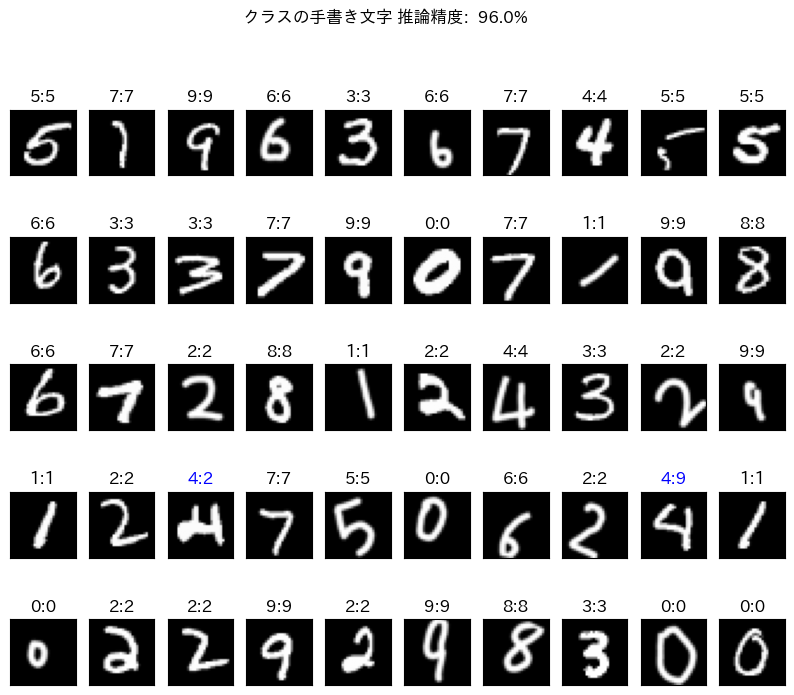

In [18]:
inputs, labels = next(iter(test_loader))

n_input = inputs[0].shape[0]
n_output = 10
n_hidden = 128

net = Net2(
    n_input=n_input,
    n_output=n_output,
    n_hidden=n_hidden
) 
net.to(device) 
state_dict = torch.load(mnist_and_hand_digits_model_path, map_location=device) 
net.load_state_dict(state_dict)
net.eval()

plt.figure(figsize=(10, 8))

with torch.no_grad():
    for images, labels in test_loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    predicted = torch.max(outputs, 1)[1]

    total = 0
    correct = 0

    for i in range(50):
        total += 1
        ax = plt.subplot(5, 10, i + 1)

        image = images[i]
        label = labels[i].item()
        pred = predicted[i].item()

        if (pred == label):
            c = 'k'
            correct += 1
        else:
            c = 'b'

        image2 = (image + 1)/ 2

        plt.imshow(image2.reshape(28, 28),cmap='gray')
        ax.set_title(f'{label}:{pred}', c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    accuracy = (correct / total) * 100
    plt.suptitle(f"クラスの手書き文字 推論精度: {accuracy: .1f}%")

In [19]:
import shutil
import os
from glob import glob
import random

zip_root_my_hand_digits = "./my_hand_digits.zip"
data_root_my_hand_digits = "./data/my_hand_digits"
data_root_my_hand_digits_tmp = f"{data_root_my_hand_digits}/tmp"

shutil.unpack_archive(zip_root_my_hand_digits, data_root_my_hand_digits_tmp)

for n in range(10):
    no_dir = f"{data_root_my_hand_digits}/{n}"
    os.makedirs(no_dir, exist_ok=True)

my_hand_digits_images = glob(f"{data_root_my_hand_digits_tmp}/*.png")
print("画像ファイル数:", len(my_hand_digits_images))
random.seed(0)
random.shuffle(my_hand_digits_images)

for file in my_hand_digits_images:
    file_name = os.path.basename(file)
    label = file_name[0]
    dest_dir = f"{data_root_my_hand_digits}/{label}"
    shutil.move(file, f"{dest_dir}/{file_name}")

shutil.rmtree(data_root_my_hand_digits_tmp)

画像ファイル数: 50


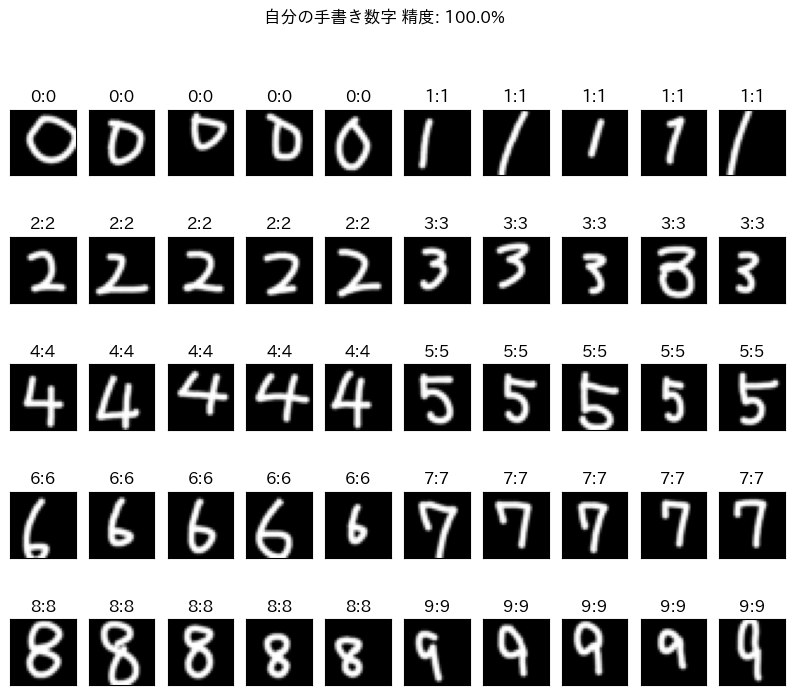

In [21]:
verify_set = datasets.ImageFolder(
    root = data_root_my_hand_digits,
    transform = transform_hand_digits
)

verify_loader = DataLoader(
    verify_set,
    batch_size = batch_size,
    shuffle = False
)

inputs, labels = next(iter(verify_loader))

n_input = inputs[0].numel()
n_output = 10
n_hidden = 128

net = Net2(
    n_input=n_input,
    n_output=n_output,
    n_hidden=n_hidden
) 
net.to(device) 
state_dict = torch.load(mnist_and_hand_digits_model_path, map_location=device) 
net.load_state_dict(state_dict)
net.eval()

plt.figure(figsize=(10, 8))

with torch.no_grad():
    for images, labels in verify_loader:
        break

    inputs = images.to(device)
    labels = labels.to(device)

    outputs = net(inputs)
    predicted = torch.max(outputs, 1)[1]

    total = 0
    correct = 0

    for i in range(images.size()[0]):
        total += 1
        ax = plt.subplot(5, 10, i + 1)

        image = images[i]
        label = labels[i].item()
        pred = predicted[i].item()

        if (pred == label):
            c = 'k'
            correct += 1
        else:
            c = 'b'

        image2 = (image + 1)/ 2

        plt.imshow(image2.reshape(28, 28),cmap='gray')
        ax.set_title(f'{label}:{pred}', c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    accuracy = (correct / total) * 100
    plt.suptitle(f'自分の手書き数字 精度: {accuracy:.1f}%')